## Library imports

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
model.eval();

Using cache found in C:\Users\Jayaraman/.cache\torch\hub\pytorch_vision_v0.10.0


In [3]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [4]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

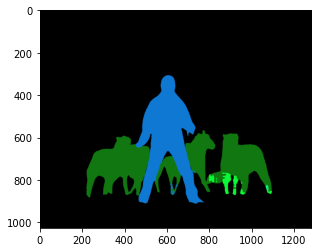

In [5]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

In [6]:
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

## Helper functions

In [2]:
def getProjectRootPath() -> str:
    projectRootPath  = os.path.dirname(sys.path[0])
    return projectRootPath

projectRootPath = getProjectRootPath()

In [3]:
def exportModel(model : nn.Module, sampleInput : torch.Tensor, outputPath : str):
    model.eval();
    torch.onnx.export(model,               # model being run
                  sampleInput,                         # model input (or a tuple for multiple inputs)
                  outputPath,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['Model Input'],   # the model's input names
                  output_names = ['Model Output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})
    return

## File constants

In [4]:
# saanple tensor for model input
sampleInput = torch.Tensor(1, 3, 224, 224)

# file path constants
dataFolder = os.path.join(projectRootPath, *['data'])
modelOutputPath = os.path.join(dataFolder, *['FCN_out.onnx'])

In [5]:
from torchvision.models.segmentation import fcn_resnet50

In [6]:
model = fcn_resnet50()

In [7]:
exportModel(model, sampleInput, outputPath=modelOutputPath)

D:\surya\miniconda37\envs\imgseg\lib\site-packages\torch\onnx\utils.py:1294: UserWarning: Provided key input for dynamic axes is not a valid input/output name
  warnings.warn("Provided key {} for dynamic axes is not a valid input/output name".format(key))
D:\surya\miniconda37\envs\imgseg\lib\site-packages\torch\onnx\utils.py:1294: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn("Provided key {} for dynamic axes is not a valid input/output name".format(key))
D:\surya\miniconda37\envs\imgseg\lib\site-packages\torch\onnx\symbolic_helper.py:382: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transfo

In [9]:
for name,_ in model.named_children():
    print(name)

backbone
classifier


In [11]:
model.classifier

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [12]:
backboneOutput = model.backbone(sampleInput)

In [27]:
exportModel(model.classifier, backboneOutput['out'], os.path.join(dataFolder, *['FCNHead.onnx']))